1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import csv 

data = pd.read_csv('data/data_000637.txt').head(15000) 
pd.set_option('display.max_rows', None)
print(data) 
print(data.info()) 

       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0         1     0          123  3869200167        2374        26
1         1     0          124  3869200167        2374        27
2         1     0           63  3869200167        2553        28
3         1     0           64  3869200167        2558        19
4         1     0           64  3869200167        2760        25
5         1     0           63  3869200167        2762         4
6         1     0           61  3869200167        2772        14
7         1     0          139  3869200167        2776         0
8         1     0           62  3869200167        2774        21
9         1     0           60  3869200167        2788         7
10        1     1            7  3869200167        2785         4
11        1     0           64  3869200167        2786        19
12        1     1            6  3869200167        2792        18
13        1     0           36  3869200167        2791        23
14        1     0        

2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [3]:
bx = data["BX_COUNTER"]
the_bx = max(bx) + 1
print("Estimated number of BX in a ORBIT:", the_bx)

Estimated number of BX in a ORBIT: 3564


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [4]:
import datetime as dt

itime = dt.datetime.now()
print("Begin time:", itime)
data_copy = data
time =  data['TDC_MEAS'] *(25/30) + data['BX_COUNTER'] * 25 + data['ORBIT_CNT']*the_bx*25
data_copy['absolute_time'] = time
data_copy
ftime = dt.datetime.now()
print("End time:", ftime)
print("Elapsed time:", (ftime - itime))

Begin time: 2022-11-30 14:18:22.233936
End time: 2022-11-30 14:18:22.243938
Elapsed time: 0:00:00.010002


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [5]:
data["absolute_time_ns"] = data['TDC_MEAS'] *(25 / 30) + data['BX_COUNTER'] * 25 +data['ORBIT_CNT']*the_bx*25
# data

5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [6]:
grouped =  data.groupby('TDC_CHANNEL').sum().sort_values(by = ['HEAD']).iloc[-3:]
grouped

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,absolute_time,absolute_time_ns
TDC_CHANNEL,,,,,,,
63,749,6,2898030982000,1364359,11085,2.582146e+17,2.582146e+17
64,752,17,2909638583165,1394717,10889,2.592488e+17,2.592488e+17
139,1268,389,4906145905369,2247027,0,4.371376e+17,4.371376e+17


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [10]:
count = data.ORBIT_CNT.unique().size
print("non empty orbits are: " + str(count))

non empty orbits are: 150


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [8]:
unique_orbit= data['ORBIT_CNT'][data['TDC_CHANNEL'] == 139]
unique_orbit = unique_orbit.drop_duplicates()

print('Count the number of unique orbits is: --> ', len(unique_orbit))
unique_orbit

Count the number of unique orbits is: -->  150


7        3869200167
48       3869200168
136      3869200169
257      3869200170
359      3869200171
464      3869200172
559      3869200173
639      3869200174
770      3869200175
903      3869200176
952      3869200177
1066     3869200178
1157     3869200179
1292     3869200180
1372     3869200181
1494     3869200182
1549     3869200183
1667     3869200184
1731     3869200185
1866     3869200186
1966     3869200187
2057     3869200188
2187     3869200189
2220     3869200190
2300     3869200191
2455     3869200192
2513     3869200193
2666     3869200194
2819     3869200195
2904     3869200196
2953     3869200197
3072     3869200198
3207     3869200199
3331     3869200200
3369     3869200201
3475     3869200202
3596     3869200203
3666     3869200204
3768     3869200205
3856     3869200206
3970     3869200207
4079     3869200208
4212     3869200209
4275     3869200210
4359     3869200211
4472     3869200212
4591     3869200213
4692     3869200214
4744     3869200215
4872     3869200216


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [11]:
FPGA_0 = pd.Series(data[data['FPGA'] == 0]['TDC_CHANNEL'].value_counts())
FPGA_1 = pd.Series(data[data['FPGA'] == 1]['TDC_CHANNEL'].value_counts())
print("Series FPGA is 0 :\n" , FPGA_0)
print("\nSeries FPGA is 1 :\n" , FPGA_1)

Series FPGA is 0 :
 139    879
63     743
64     735
61     555
62     529
60     512
59     456
58     387
57     367
56     356
54     282
53     258
123    202
124    193
51     188
50     181
48     172
49     156
47     145
46     139
44     136
45     125
40     123
43     119
42     107
38      98
36      88
41      87
28      75
37      73
32      71
122     71
121     63
24      60
35      59
26      51
31      49
20      47
33      47
120     46
119     45
29      42
27      41
23      39
22      37
16      36
117     35
8       33
25      33
19      33
88      30
18      29
89      28
118     26
87      26
84      26
21      25
82      25
92      25
85      24
17      24
116     23
11      22
90      22
13      21
86      21
115     21
7       21
10      20
81      19
5       19
71      19
74      19
72      19
4       19
113     18
111     18
6       18
83      18
114     17
80      17
79      17
96      17
94      17
73      17
3       16
2       16
78      16
91      15
1

9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

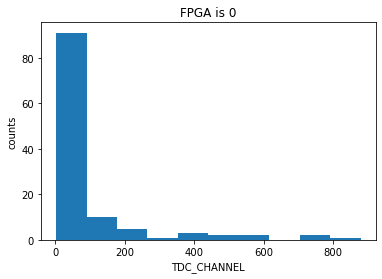

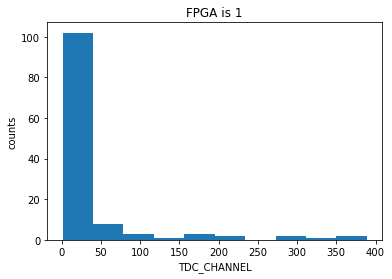

In [15]:
plt.hist(FPGA_0)
plt.title('FPGA is 0')
plt.xlabel('TDC_CHANNEL')
plt.ylabel('counts')
plt.show()
plt.hist(FPGA_1)
plt.title('FPGA is 1')
plt.xlabel('TDC_CHANNEL')
plt.ylabel('counts')
plt.show()